In [7]:
#!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import re
import string
from spellchecker import SpellChecker

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

stop=set(stopwords.words('english'))

In [9]:
tweet = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [10]:
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


Showing some of the tweets which have a target of '0', i.e. not diaster tweets

In [11]:
tweet[tweet['target']==0].head(3)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0


([<matplotlib.patches.Wedge at 0x7fb159177510>,
 [Text(-1.0732513534192263, -0.24110481617711227, '0'),
  Text(1.0732513534192263, 0.2411048161771121, '1')],
 [Text(-0.5854098291377597, -0.1315117179147885, '57.0%'),
  Text(0.5854098291377597, 0.1315117179147884, '43.0%')])

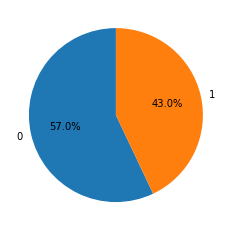

In [12]:
distribution = tweet.target.value_counts()
plt.pie(distribution,
       labels=distribution.keys(), 
       autopct='%1.1f%%', 
       startangle=90)

The distribution seems to contain more tweets which are not related to a disater than those that are.

Time to focus on cleaning the tweets up for the model

In [13]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

Many of the tweets habve urls and other html formatting in them which we will want to remove

In [14]:
def remove_links(text):
    link = re.compile(r'https?://\S+|www\.\S+')
    return link.sub(r'',text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [15]:
df['text']=df['text'].apply(lambda x : remove_links(x))
df['text']=df['text'].apply(lambda x : remove_html(x))
df['text']=df['text'].apply(lambda x: remove_emoji(x))
df['text']=df['text'].apply(lambda x : remove_punct(x))

With some of the extra mess gone from the tweets, we can make some adjustments to misspellings in an attempt to have consistent words

In [16]:
spell = SpellChecker()
def spell_check(text):
    corrected = []
    misspellings = spell.unknown(text.split())
    for word in text.split():
        if word in misspellings:
            corrected.append(spell.correction(word))
        else:
            corrected.append(word)
    return " ".join(corrected)

In [17]:
# This may take a while to run
#df['text']=df['text'].apply(lambda x : spell_check(x))

Now that we have some great, clean #tweets, its time to get into things

I am going to be working the BERT model, as I have been reading some of the implementations on Kaggle and it seems to be producing good results

In [43]:
#bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1', trainable=True)

In [19]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [20]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
vocab = bert_layer.resolved_object.vocab_file.asset_path.numpy()
lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab, lower_case)

In [39]:
tweet_input = bert_encode(tweet.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = tweet.target.values

In [31]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [33]:
train_history = model.fit(
    tweet_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

model.save('model.h5')

Train on 6090 samples, validate on 1523 samples
Epoch 1/3
6090/6090 [==============================] - 95s 16ms/sample - loss: 0.3427 - accuracy: 0.8583 - val_loss: 0.3939 - val_accuracy: 0.8391
Epoch 2/3
6090/6090 [==============================] - 89s 15ms/sample - loss: 0.2446 - accuracy: 0.9046 - val_loss: 0.4048 - val_accuracy: 0.8306
Epoch 3/3
6090/6090 [==============================] - 89s 15ms/sample - loss: 0.1804 - accuracy: 0.9330 - val_loss: 0.4592 - val_accuracy: 0.8286


In [41]:
test_prediction = model.predict(test_input)

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * [<tf.Tensor 'inputs:0' shape=(None, 160) dtype=int64>, <tf.Tensor 'inputs_1:0' shape=(None, 160) dtype=int64>, <tf.Tensor 'inputs_2:0' shape=(None, 160) dtype=int64>]
    * False
    * None
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids')]
    * True
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_mask'), TensorSpec(shape=(None, None), dtype=tf.int32, name='input_type_ids')]
    * False
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/1'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/2')]
    * True
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * [TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/0'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/1'), TensorSpec(shape=(None, None), dtype=tf.int32, name='inputs/2')]
    * False
    * None
  Keyword arguments: {}

In [ ]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)